Iris data 는 네 종류의 변수를 이용하여 Iris 의 품종을 예측하는데 이용되는 데이터입니다. Scikit-learn 에서도 해당 데이터를 제공하며, `data` 와 `target` 자체가 numpy.ndarray 로 정제되어 있습니다. 이를 pandas DataFrame 으로 변환하여 데이터를 살펴봅니다.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import load_iris

iris = load_iris()
print(f'iris keys = {iris.keys()}')

X = iris['data']
labels = iris['target']

# ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
columns = [name[:-5].replace(' ', '_') for name in iris['feature_names']]
iris_df = pd.DataFrame(data=iris.data, columns=columns)
iris_df['labels'] = labels
iris_df.head(5)

/usr/local/var/pyenv/versions/3.7.7/envs/lovit3.7.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


iris keys = dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


,sepal_length,sepal_width,petal_length,petal_width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


데이터마다 스캐일에 차이가 있습니다. 이를 min-max scaler 를 이용하여 이를 정규화 합니다.

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X[:2]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667]])

UMAP 을 이용하여 4차원의 데이터를 2차원으로 구분합니다. `target_weight` 를 설정하면 labels 의 영향력을 조절할 수 있습니다.

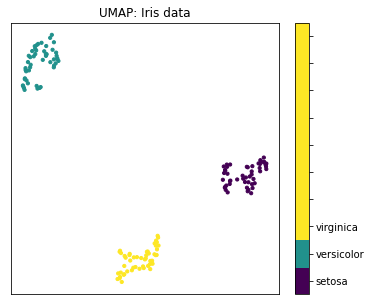

In [3]:
import umap

xy = umap.UMAP(n_neighbors=10, target_weight=0.1).fit_transform(X, y=labels)

def draw(xy, classes, color, title):    
    fig, ax = plt.subplots(1, figsize=(6, 5))
    plt.scatter(xy[:,0], xy[:,1], s=10, c=color, alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    plt.title(title)
    return fig

classes = list(iris.target_names)
title = 'UMAP: Iris data'
fig = draw(xy, classes, labels, title)

그런데 레이블 정보를 이용하지 않아도 PCA 를 통하여 2차원 벡터를 학습해보니 종별로 어느 정도 구분이 됩니다. 즉 PCA 를 이용하여 변수를 2개로 줄이더라도 classifier models 이 잘 학습될 가능성이 높습니다.

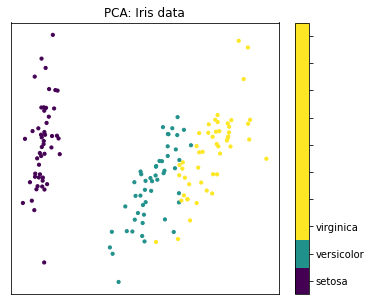

In [4]:
from sklearn.decomposition import PCA

xy = PCA(n_components=2).fit_transform(X)
title = 'PCA: Iris data'
fig = draw(xy, classes, labels, title)

t-SNE 를 이용하여 학습한 경우에도 어느 정도 클래스가 구분되어 2차원 벡터로 표현됩니다. 즉 Iris data 는 판별 문제에 매우 쉬운 데이터라는 의미입니다.

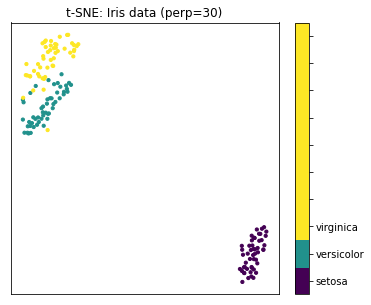

In [5]:
from sklearn.manifold import TSNE

xy = TSNE(n_components=2, perplexity=30).fit_transform(X)
title = 't-SNE: Iris data (perp=30)'
fig = draw(xy, classes, labels, title)

Perplexity 를 아주 작게 줄여보니 그 구분이 조금 약하고, 몇몇 점들이 튕겨져 나가듯이 그림이 그려집니다. 이는 perplexity 의 수치가 매우 작기 때문에 임베딩 모델이 잘 학습되지 않은 것입니다.

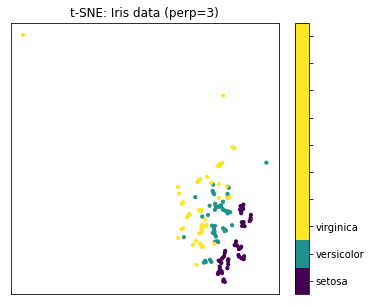

In [6]:
from sklearn.manifold import TSNE

np.random.seed(2)
xy = TSNE(n_components=2, perplexity=3).fit_transform(X)
title = 't-SNE: Iris data (perp=3)'
fig = draw(xy, classes, labels, title)

`labels` 와 `classes` 의 변수값이 무엇인지 확인을 합니다.

In [7]:
print(labels[:3])
print(classes[:3])

[0 0 0]
['setosa', 'versicolor', 'virginica']


Seaborn 대신 Bokeh 를 이용하여 plotting 을 할 준비를 합니다. 아래의 코드는 Bokeh 를 이용하여 그림을 그릴 때 중요한 개념이 많이 포함되어 있습니다. 첫째 `output_notebook()` 은 IPython notebook 에서 한 번 이상 실행해야 합니다. 이는 `%matplotlib inline` 처럼 notebook 에 그림을 출력하겠다고 선언하는 부분입니다. 정상적으로 실행이 되면 아래와 같은 메시지가 출력됩니다.

```
 BokehJS 1.4.0 successfully loaded.
```

Bokeh 는 명시적으로 그림을 그릴 도화지 p 를 figure() 함수를 이용하여 준비합니다. height, width, title 외에도 다양한 값을 입력할 수 있습니다. 이 때 `tooltips` 를 만들 수도 있고, 혹은 이용하지 않을 수도 있습니다. Bokeh 의 장점 중 하나인 Hover tool 을 이용하기 위하여 tooltips 를 준비해 봅니다. 이 값의 의미는 만들어진 그림에 마우스를 올려보면 곧바로 알게 됩니다.

color code 는 'white', 'lightgrey' 처럼 색의 이름을 입력하거나 '#ad1313' 처럼 HTML color code 를 입력할 수도 있습니다. 혹은 이러한 color code 가 미리 준비되어 있는 palettes 를 이용할 수도 있습니다. 이에 대해서는 `bokeh palettes` 로 구글링을 해보시기 바랍니다. 처음 검색되는 페이지를 보시면 색상 예시를 볼 수 있습니다.

ColumnDataSource 는 seaborn 에서 pandas.DataFrame 을 입력하는 것처럼 테이블 형식으로 구성된 데이터 입니다. 그리고 도화지 위에 `scatter()` 함수를 실행시킵니다. 이 역시 seaborn 의 `relplot()` 함수처럼 source 를 입력하고 scatter 함수가 필요한 인자의 이름을 scatter(x='x') 처럼 입력하면 됩니다. 혹은 `alpha=0.7` 처럼 몇몇 값은 직접 입력해도 됩니다.

In [8]:
from bokeh.palettes import Spectral
from bokeh.plotting import output_notebook, show, figure
from bokeh.io import save
from bokeh.models import ColumnDataSource


output_notebook()

def draw_bokeh(xy, classes, labels, title=None, p=None):
    if p is None:
        tooltips = [
            # (field name, value)
            # @는 source 내 변수 이름, $는 plotting 에서 사용하는 변수 이름
            ("data index", "$index point"),
            ("class", "@class"),
            ("(x, y)", "($x, $y)")
        ]
        p = figure(height=400, width=400, title=title, tooltips=tooltips)

    # prepare colormaps
    n_classes = len(classes)
    colormap = Spectral[n_classes]

    x = xy[:,0]
    y = xy[:,1]
    color = [colormap[l] for l in labels]
    class_name = [classes[l] for l in labels]

    # like pandas.DataFrame
    source = ColumnDataSource({
        'x': x, 'y': y, 'color': color, 'class': class_name
    })

    p.scatter(x='x', y='y', fill_color='color', line_color=None, source=source, alpha=0.7)
    return p

Loading BokehJS ...

앞서 만든 함수를 이용하여 그림을 그려봅니다. 그 뒤 show 함수에 Figure 를 입력하면 그림이 출력됩니다.

In [9]:
p = draw_bokeh(xy, classes, labels, title='t-SNE + Bokeh')
show(p)

저장은 save 함수를 이용할 수 있습니다. 저장된 HTML 파일도 위 output cell 의 그림처럼 동적인 그림입니다.

In [10]:
_ = save(p, 'tsne_bokeh.html')

/usr/local/var/pyenv/versions/3.7.7/envs/lovit3.7.7/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/var/pyenv/versions/3.7.7/envs/lovit3.7.7/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


만약 그림의 크기가 너무 작다면 그림을 그린 후 이를 수정할 수 있습니다. 그림 내 요소가 아닌, 그림 자체에 대한 요소들은 수정이 가능합니다.

In [11]:
p.height = 600
p.width = 600
p.title.text = 't-SNE (perplexity=2) + Bokeh'
show(p)

Bokeh 는 seaborn 보다 다양한 그림을 그릴 수 있지만, 많은 과정들을 직접 구현해야 합니다. 그런데 이런 함수는 매번 반복하여 이용하니 이를 잘 저장한 뒤, 필요에 따라 import 하여 사용하면 좋습니다.